In [28]:
import ExonExonData as eed
import pathlib
cwd = pathlib.Path.cwd()
import pandas
import re
import pickle
from Heatmaps import heatmapv2 as heatmap
from Heatmaps import _undigitize_seq as undigit
from TimeEmbedding import time_embedding_1D as te_1d
from ExonExonPlots import plots_v2
from TimeEmbedding import time_embedding_v2
from TimeEmbedding import matplotfigure
from TimeEmbedding import time_embedding
import matplotlib.pyplot as plt

import numpy
from Heatmaps import heat_embedding
from Heatmaps import heatmapv2 as heatmap
from Heatmaps import _undigitize_seq as undigit
from Heatmaps import _reorder_frame as reorder_frame

from MomentCalculations import moments_v2
from MomentCalculations import moments
from MomentCalculations import _unrenormalize
from MomentCalculations import multiple_species_plots
from MomentCalculations import moments_v3
from Moment_Functions import moments_generic

Does Time embedding for Cancer and Normal data. Uses 20 Post and 20 Ant nucleotides (by default)

In [29]:
normal_file = cwd.parent / "Data_Files" / "Primates" / "Genetics" / "Homo_sapiens" / "G_Data" / "Normal_Exon2Exon.xlsx"
ut_file = cwd.parent / "Data_Files" / "UTData_fs.csv"
uh_file = cwd.parent / "Data_Files" / "Fusion_AllConfidence.pkl"

In [30]:
normal_data = pandas.read_excel(normal_file, sheet_name = "sheet1")
ut_data = pandas.read_csv(ut_file)
uh_data = pandas.read_pickle(uh_file)

In [31]:
def clean_seq(seq: str, kmer0: int = 0, kmerK: int = 20):
    '''
    kmer0 is the start poisition. kmerK is the end position
    '''
    if isinstance(seq, str):
        if len(seq) < (kmerK - kmer0):
            return pandas.NA
        
        seq = seq.upper()
        seq = seq[kmer0: kmerK]

        if re.search(r"(\.|\?|\_|\||\-)", seq):
            return pandas.NA
        else:
            return seq
    
    else:
        return pandas.NA
    

In [32]:
# print(normal_data.columns)
# print(ut_data.columns)
# print(ut_data["Unnamed: 19"].head())  # Unnamed: 19 = Anterior 20
# print(ut_data["Unnamed: 18"].head())  # Unnamed: 18 = Posterior 20
# print(uh_data.columns)
# print(uh_data["Tail"].head())
# print(uh_data["Tail"].apply(lambda x: x[0: 20] if isinstance(x, str) else None))

In [33]:
normal_data["Seq"] = normal_data["Posterior_20"] + normal_data["Anterior_20"]
normal_data["Length"] = normal_data["Seq"].apply(lambda x: len(x))
normal_data["Classificaion"] = "exon"

print(normal_data.shape)

(37415, 8)


In [34]:
ut_data = ut_data.rename(columns={"Unnamed: 19": "Anterior 20", "Unnamed: 18": "Posterior 20"})
ut_data["Seq"] = ut_data["Posterior 20"] + ut_data["Anterior 20"]
ut_data = ut_data.dropna()
ut_data = ut_data.reset_index()
ut_data["Length"] = ut_data["Seq"].apply(lambda x: len(x))
ut_data["Classificaion"] = "exon"

print(uh_data.shape)

(17377, 35)


In [35]:
uh_data["Anterior 20"] = uh_data["Tail"].apply(lambda x: clean_seq(x))
uh_data["Posterior 20"] = uh_data["Head"].apply(lambda x: clean_seq(x, kmer0=len(x) - 20, kmerK=len(x)))
uh_data["Seq"] = uh_data["Posterior 20"] + uh_data["Anterior 20"]
uh_data = uh_data.dropna()
try:
    uh_data = uh_data.reset_index(drop = True)
except Exception as e:
    print(type(e))
    print(e)

uh_data["Length"] = uh_data["Seq"].apply(lambda x: len(x))
uh_data["Classificaion"] = "exon"

print(uh_data.shape)

(15683, 40)


Kneading Transform

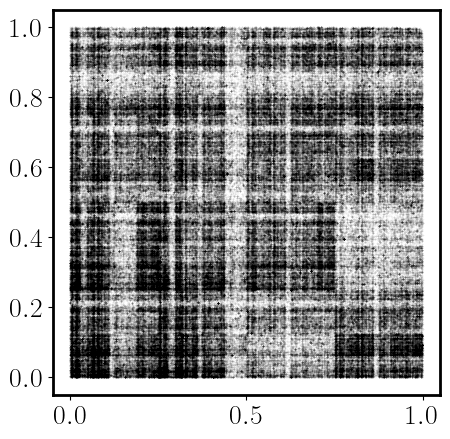

In [36]:
rows, _ = normal_data.shape

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)


for row in range(rows):
    seq = normal_data.loc[row, "Seq"]
    xy = time_embedding(seq)
    plt.plot(xy[:, 0], xy[:, 1], markersize = 0.01, marker = "s", linestyle = "", color = "k")

plt.show()

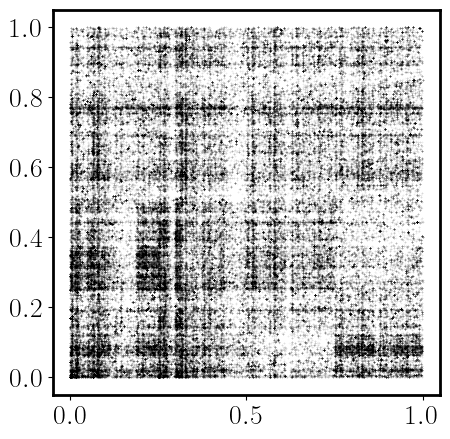

In [37]:
rows, _ = ut_data.shape

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)


for row in range(rows):
    seq = ut_data.loc[row, "Seq"]
    xy = time_embedding(seq)
    plt.plot(xy[:, 0], xy[:, 1], markersize = 0.01, marker = "s", linestyle = "", color = "k")

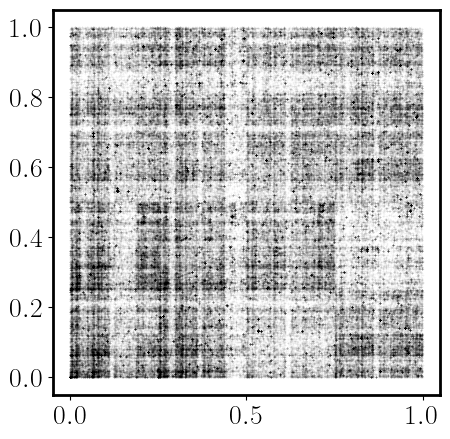

In [38]:
rows, _ = uh_data.shape

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)


for row in range(rows):
    seq = uh_data.loc[row, "Seq"]
    xy = time_embedding(seq)
    if xy is None:
        pass
    else:
        plt.plot(xy[:, 0], xy[:, 1], markersize = 0.01, marker = "s", linestyle = "", color = "k")

Heatmaps

In [39]:
transform = None
k = 6
colors: list = ['blue', 'orange', 'orangered', 'red']
bounds: list = [0, 0.452, 1.45, 2.36, 3.2] # 0.98

In [40]:
_, normal_exon, *_ = heat_embedding(normal_data,
                                    # n = n,
                                    # k_m = k, k_p = k,
                                    just_import = True,
                                    log_transform = transform)  # Just import is turned on because I have one dictionary with all the data. I'll use that one set for all the images from now on. Just makes things a little faster and easier.

Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Exon2Exon\Cancer\Normal_2020.png


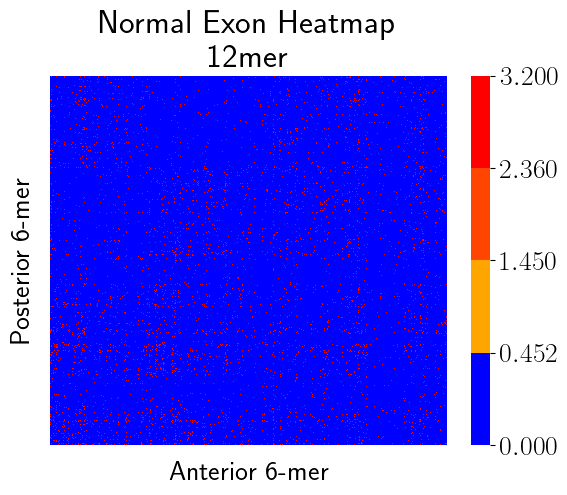

In [41]:
heatmap(normal_exon, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"Normal Exon Heatmap\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Exon2Exon" / "Cancer" / f"Normal_2020.png")

In [42]:
_, ut_exon, *_ = heat_embedding(ut_data,
                                # n = n,
                                # k_m = k, k_p = k,
                                just_import = True,
                                log_transform = transform)  # Just import is turned on because I have one dictionary with all the data. I'll use that one set for all the images from now on. Just makes things a little faster and easier.

Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Exon2Exon\Cancer\UT_2020.png


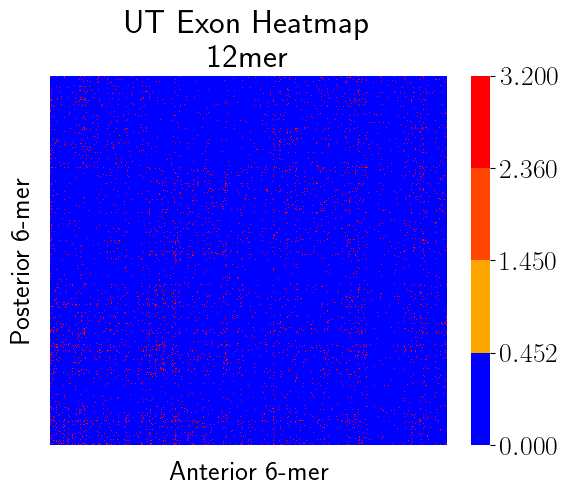

In [43]:
heatmap(normal_exon, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"UT Exon Heatmap\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Exon2Exon" / "Cancer" / f"UT_2020.png")

In [44]:
_, uh_exon, *_ = heat_embedding(uh_data,
                                # n = n,
                                # k_m = k, k_p = k,
                                just_import = True,
                                log_transform = transform)  # Just import is turned on because I have one dictionary with all the data. I'll use that one set for all the images from now on. Just makes things a little faster and easier.

Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Exon2Exon\Cancer\UH_2020.png


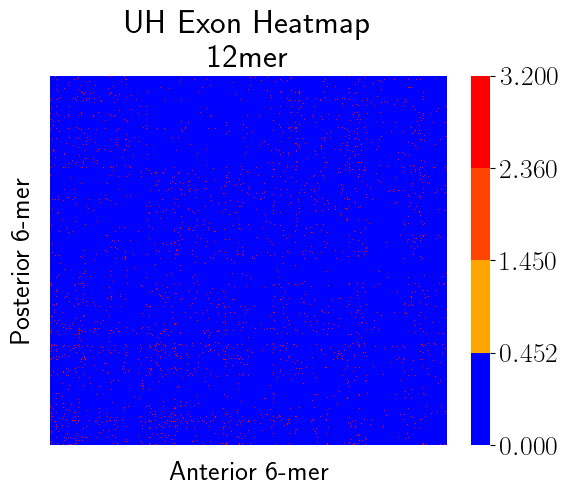

In [45]:
heatmap(uh_exon, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"UH Exon Heatmap\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Exon2Exon" / "Cancer" / f"UH_2020.png")

In [46]:
step = 100
max_n = 5
min_n = 0.5
xticks = {0.5: 0.5, 1.0: 1.0, 1.5: 1.5, 2.0: 2.0, 2.5: 2.5, 3.0: 3.0}
ms = [n / step for n in range(int(step*(min_n)), int(step*max_n) + 1)]
title = f"E v I log w/N divided"

In [47]:
normal_frame = reorder_frame(pandas.DataFrame(normal_exon), transpose = True)

normal_frame = _unrenormalize(normal_frame, 12, log2 = False)
normal_moments = moments_generic(normal_frame, ms, k = 6, N_value = True)

		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m = 0.8

In [48]:
ut_frame = reorder_frame(pandas.DataFrame(ut_exon), transpose = True)

ut_frame = _unrenormalize(ut_frame, 12, log2 = False)
ut_moments = moments_generic(ut_frame, ms, k = 6, N_value = True)

		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m = 0.8

In [49]:
uh_frame = reorder_frame(pandas.DataFrame(uh_exon), transpose = True)

uh_frame = _unrenormalize(uh_frame, 12, log2 = False)
uh_moments = moments_generic(uh_frame, ms, k = 6, N_value = True)

		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m = 0.8

Species = Normal
plotting for 12-mer
Species = UT
plotting for 12-mer
Species = UH
plotting for 12-mer


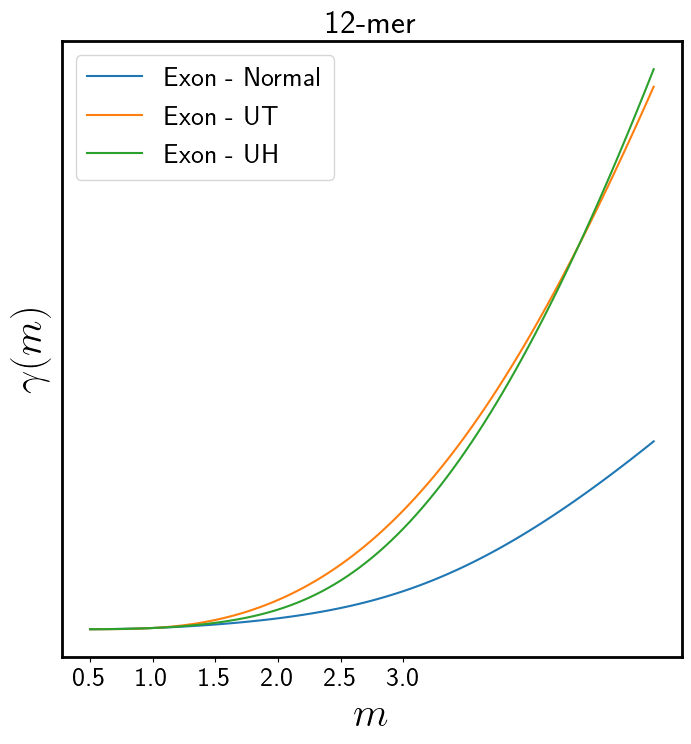

In [50]:
me_plots = {"Normal": {"data": {6: normal_moments}, "marker": None}, "UT": {"data": {6: ut_moments}, "marker": None}, "UH": {"data": {6: uh_moments}, "marker": None}}
uni = None
mi_plots = None
# mn = {"Human": {"data": mn, "marker": None}}
mn_plots = None

multiple_species_plots(ms, me_plots, mi_plots, mn_plots, uni, cwd / "TE_Images_ForPaper" / "Exon2Exon", x_ticks = xticks)